In [2]:
!pip install tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
import pandas as pd
import random
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [58]:
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_path = '/content/drive/MyDrive/Team 4 Potato Diseases Datasets'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)


In [59]:
from pathlib import Path
import random


# data_path = Path("/content/drive/MyDrive/Team 4 Potato Diseases Datasets")


if not data_path.exists():
    print("The specified path does not exist:", data_path)
else:

    class_images = {}


    for sub_dir in [d for d in data_path.iterdir() if d.is_dir()]:

        files = [f for f in sub_dir.iterdir() if f.is_file()]

        print(f"Class {sub_dir.name} has a total of {len(files)} images.")

        num_samples = 5
        if len(files) >= num_samples:
            class_images[sub_dir.name] = random.sample(files, num_samples)
        else:
            class_images[sub_dir.name] = files

    for class_name, images in class_images.items():
        print(f"Class {class_name} has {len(images)} sampled images: {[image.name for image in images]}")


Class Dry Rot has a total of 60 images.
Class Miscellaneous has a total of 74 images.
Class Pink Rot has a total of 57 images.
Class Healthy Potatoes has a total of 80 images.
Class Blackleg has a total of 60 images.
Class Black Scurf has a total of 58 images.
Class Common Scab has a total of 62 images.
Class Dry Rot has 5 sampled images: ['29.jpg', '33.jpg', '41.jpg', '56.jpg', '30.jpg']
Class Miscellaneous has 5 sampled images: ['32.jpg', '43.jpg', '55.jpg', '14.jpg', '10.jpg']
Class Pink Rot has 5 sampled images: ['40.jpg', '4.jpg', '10.jpg', '25.jpg', '43.jpg']
Class Healthy Potatoes has 5 sampled images: ['58.jpg', '26.jpg', '54.jpg', '32.jpg', '36.jpg']
Class Blackleg has 5 sampled images: ['60.jpg', '57.jpg', '45.jpg', '54.jpg', '55.jpg']
Class Black Scurf has 5 sampled images: ['23.jpg', '10.jpg', '49.jpg', '8.jpg', '52.jpg']
Class Common Scab has 5 sampled images: ['17.jpg', '49.jpg', '41.jpg', '47.jpg', '6.jpg']


In [20]:
!pip install matplotlib Pillow


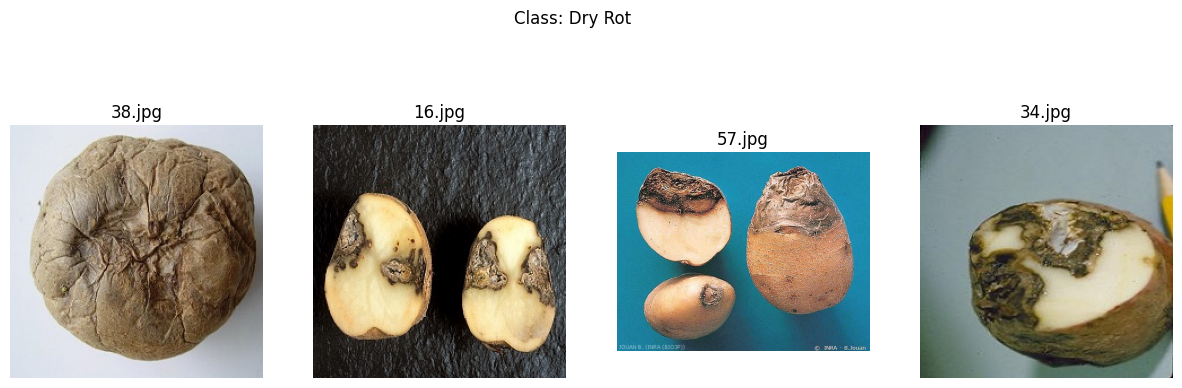

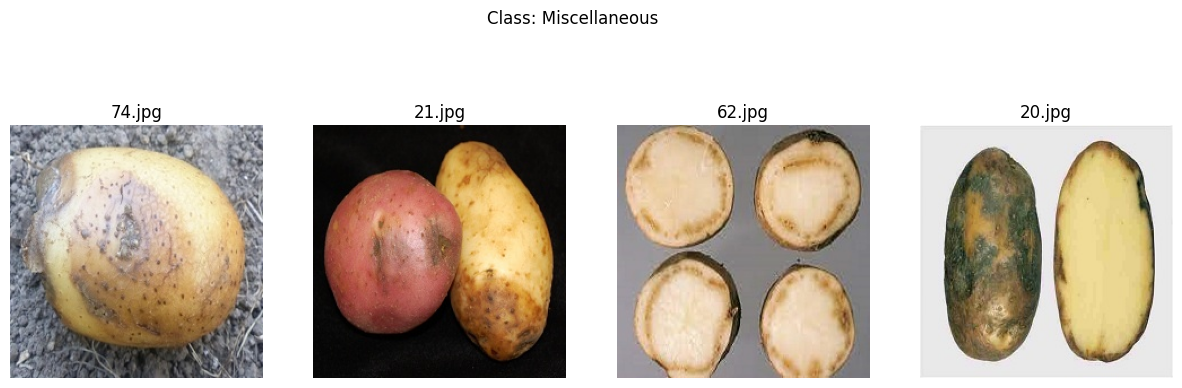

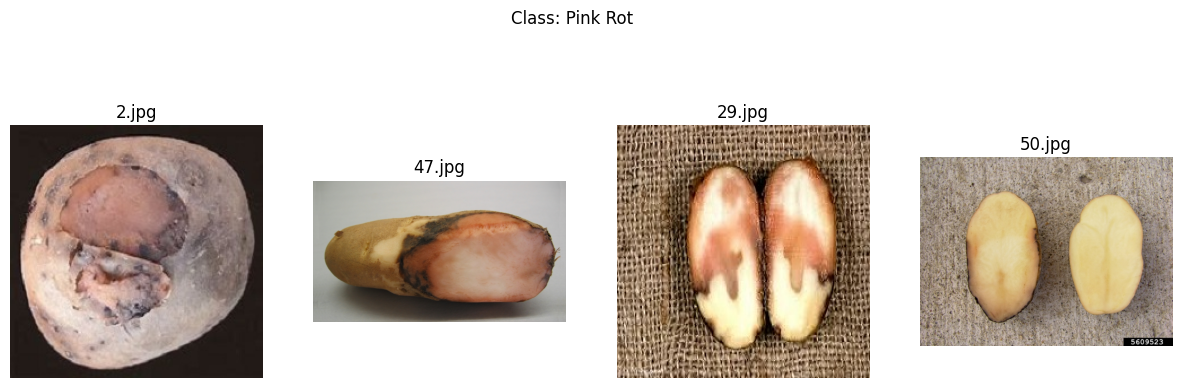

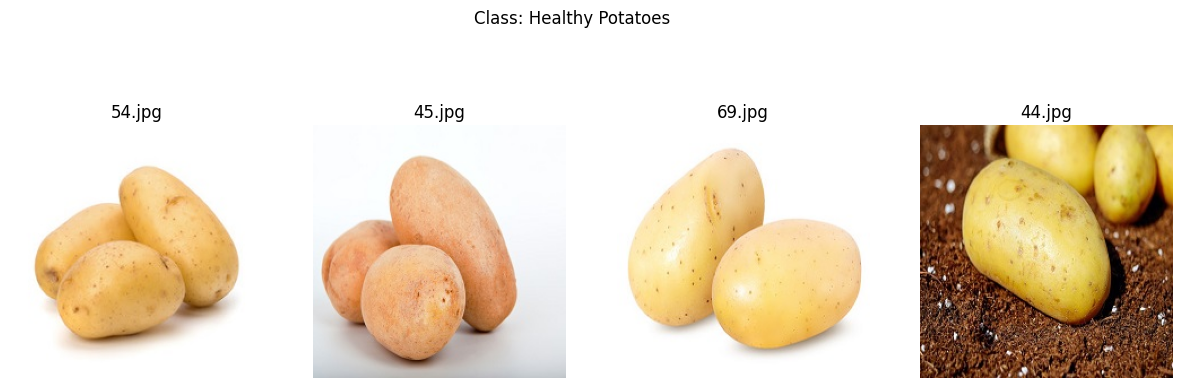

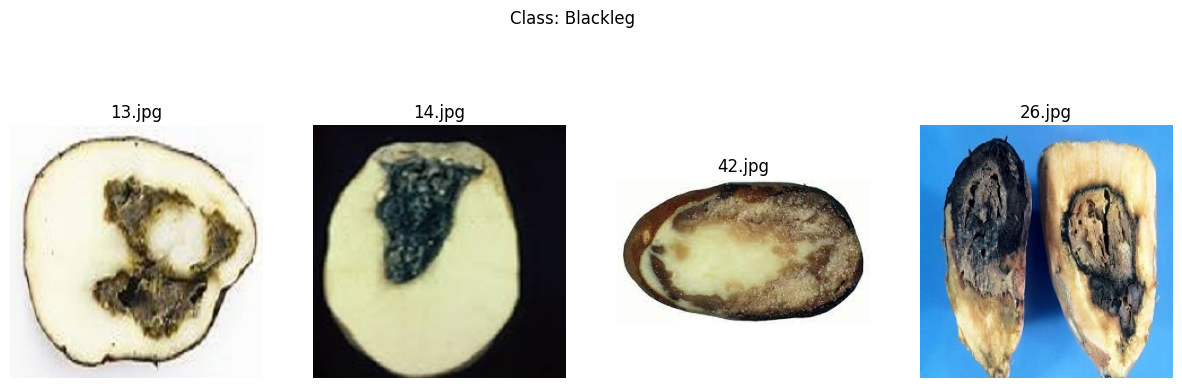

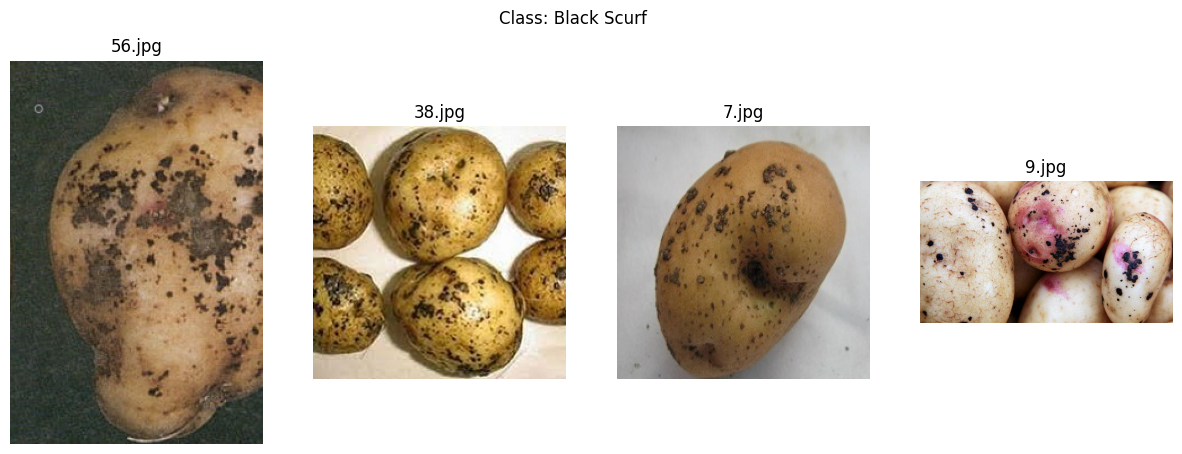

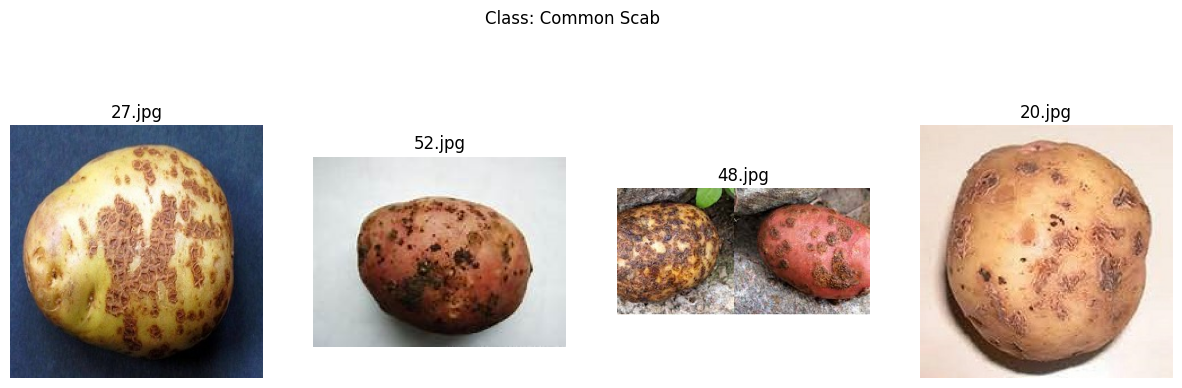

In [81]:
import os
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt



if not data_path.exists():
    print("The specified path does not exist:", data_path)
else:

    for sub_dir in [d for d in data_path.iterdir() if d.is_dir()]:

        files = [f for f in sub_dir.iterdir() if f.is_file()]

        selected_files = random.sample(files, min(len(files), 4))

        fig, axes = plt.subplots(1, len(selected_files), figsize=(15, 5))
        fig.suptitle(f'Class: {sub_dir.name}')

        for ax, image_path in zip(axes, selected_files):
            img = Image.open(image_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(image_path.name)

        plt.show()


In [61]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [76]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

n_classes = len(dataset.classes)

model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

model.classifier[1] = nn.Linear(in_features=2048, out_features=n_classes)

for name, param in model.named_parameters():
    if 'classifier.1.weight' not in name and 'classifier.1.bias' not in name:
        param.requires_grad = False


In [80]:
print(model)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [77]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 25
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy

    print(f'Epoch {epoch + 1}: Training Loss: {running_loss / len(train_loader)}, '
          f'Validation Loss: {val_loss / len(val_loader)}, '
          f'Validation Accuracy: {val_accuracy}%')




Epoch 1: Training Loss: 1.8855518400669098, Validation Loss: 1.8512048323949177, Validation Accuracy: 36.26373626373626%
Epoch 2: Training Loss: 1.739902138710022, Validation Loss: 1.7292928298314412, Validation Accuracy: 37.362637362637365%
Epoch 3: Training Loss: 1.612243761618932, Validation Loss: 1.6168362696965535, Validation Accuracy: 46.15384615384615%
Epoch 4: Training Loss: 1.4975949823856354, Validation Loss: 1.5477839708328247, Validation Accuracy: 53.84615384615385%
Epoch 5: Training Loss: 1.4031044642130535, Validation Loss: 1.4682673215866089, Validation Accuracy: 57.142857142857146%
Epoch 6: Training Loss: 1.3482736349105835, Validation Loss: 1.4185134172439575, Validation Accuracy: 57.142857142857146%
Epoch 7: Training Loss: 1.2757092316945393, Validation Loss: 1.3742501735687256, Validation Accuracy: 54.94505494505494%
Epoch 8: Training Loss: 1.195741315682729, Validation Loss: 1.339849869410197, Validation Accuracy: 62.637362637362635%
Epoch 9: Training Loss: 1.172124

In [78]:
print(f'Best Validation Accuracy: {best_accuracy}%')

Best Validation Accuracy: 67.03296703296704%


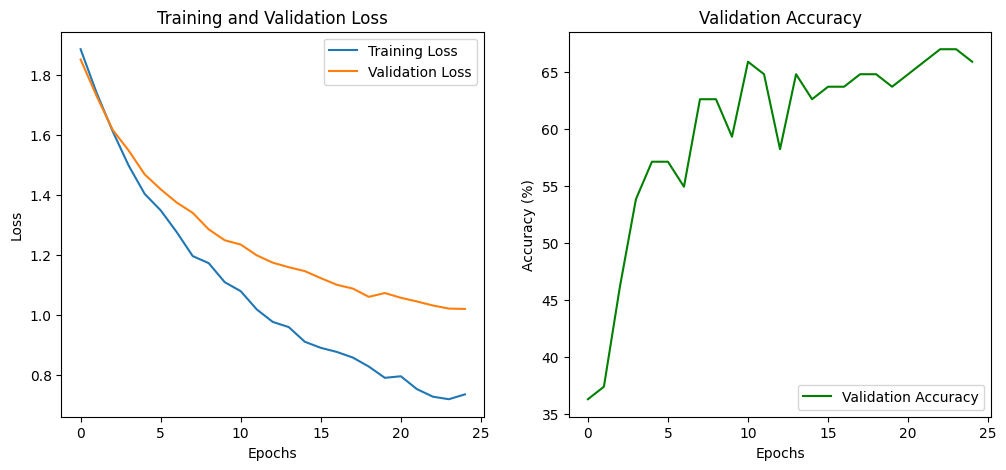

In [79]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


we can conclude the loss is decreasing with epochs and the model is able to learn the complex image representations by using the pre trained resnet model

Fine - tuning the resnet model by unfreezing the last layers may have increased the accuracy a bit more because there will be more training parameters specific to the task .